# MARATONA BEHIND THE CODE 2020

## DESAFIO 4: ALGAR

## Testes com modelo Deep Learning (TabNet)
- Autor: Rodrigo Lima
- LinkedIN: https://www.linkedin.com/in/rodrigolima82/

# Parte 01. Importando as bibliotecas

In [30]:
# Pacotes padrao
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

# Pacote do sklearn
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# Pacote de Deep Learning
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.models import load_model


# Pacote para balanceamento dos dados
from imblearn.over_sampling import SMOTE

# Desativando warnings no jupyter
import warnings
warnings.filterwarnings('ignore')


from pytorch_tabnet.tab_model import TabNetClassifier

import torch

# Parte 02. Carregando o dataset de treino

In [2]:
treino = pd.read_csv(r'train_dataset_algartech.csv')
print('Quantidade de registros e colunas: ',treino.shape)
treino.head()

Quantidade de registros e colunas:  (1370, 35)


,Idade,Local de trabalho,Pontuação teste,Departmento,Distancia casa-trabalho,Educacao,Area,Possui carro,Subordinado,Satisfação com o ambiente no emprego atual,...,Horas de trabalho padrão,Beneficios,Anos de experiencia,Horas de treinamento ultimo ano,Estilo de vida,Anos na última empresa,Anos na posição atual,Anos desde última promoção,Anos com a mesma gerência,Contratar
0,49,Cliente,279,Engenharia,8,Médio completo,Ciências das natureza,1,2,3,...,80,1,10,3,3,10,7,1,7,Não
1,33,Misto,1392,Engenharia,3,Superior incompleto - cursando,Ciências das natureza,1,5,4,...,80,0,8,3,3,8,7,3,0,Não
2,27,Cliente,591,Engenharia,2,Médio completo,Medicina,1,7,1,...,80,1,6,3,3,2,2,2,2,Não
3,32,Misto,1005,Engenharia,2,Superior incompleto,Ciências das natureza,1,8,4,...,80,0,8,2,2,7,7,3,6,Não
4,59,Misto,1324,Engenharia,3,Superior completo,Medicina,1,10,3,...,80,3,12,3,2,1,0,0,0,Não


In [3]:
# Visualizando o tipo dos dados
treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1370 entries, 0 to 1369
Data columns (total 35 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Idade                                       1370 non-null   int64 
 1   Local de trabalho                           1370 non-null   object
 2   Pontuação teste                             1370 non-null   int64 
 3   Departmento                                 1370 non-null   object
 4   Distancia casa-trabalho                     1370 non-null   int64 
 5   Educacao                                    1370 non-null   object
 6   Area                                        1370 non-null   object
 7   Possui carro                                1370 non-null   int64 
 8   Subordinado                                 1370 non-null   int64 
 9   Satisfação com o ambiente no emprego atual  1370 non-null   int64 
 10  Genero                  

,Contratar,%
Não,1178,85.985
Sim,192,14.015


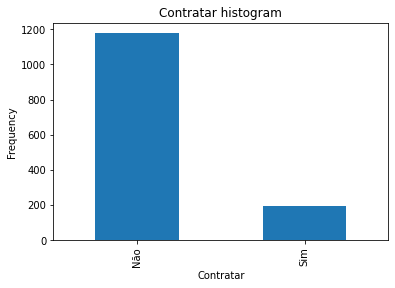

In [4]:
# Visualizando a distribuição das classes (variavel TARGET)
pd.value_counts(treino['Contratar']).plot.bar()
plt.title('Contratar histogram')
plt.xlabel('Contratar')
plt.ylabel('Frequency')

# Visualizando um df com quantidade e percentual da variavel TARGET
tmp = pd.DataFrame(treino['Contratar'].value_counts())
tmp['%'] = round(100*tmp['Contratar']/tmp['Contratar'].sum(),3)
tmp

# Parte 03. Feature Engineering

In [5]:
target = "Contratar"
n_total = len(treino)

In [6]:
train_val_indices, test_indices = train_test_split(range(n_total), test_size=0.2, random_state=0)

train_indices, valid_indices = train_test_split(train_val_indices, test_size=0.2 / 0.6, random_state=0)

In [7]:
# Removendo colunas que não serão utilizadas no treinamento
treino = treino.drop(['Possui carro','Maior de idade','Horas de trabalho padrão','Subordinado'], axis = 1)

In [8]:
categorical_columns = []
categorical_dims =  {}

for col in treino.columns[treino.dtypes == object]:
    print(col, treino[col].nunique())
    l_enc = LabelEncoder()
    treino[col] = l_enc.fit_transform(treino[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in treino.columns[treino.dtypes == 'float64']:
    treino.fillna(treino.loc[train_indices, col].mean(), inplace=True)

Local de trabalho 3
Departmento 3
Educacao 5
Area 6
Genero 2
Cargo 9
Estado civil 3
Necessita de hora extra 2
Contratar 2


In [9]:
unused_feat = []

features = [ col for col in treino.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [10]:
X_train = treino[features].values[train_indices]
y_train = treino[target].values[train_indices]

X_valid = treino[features].values[valid_indices]
y_valid = treino[target].values[valid_indices]

X_test = treino[features].values[test_indices]
y_test = treino[target].values[test_indices]

# Parte 04. Modelagem Preditiva
> - Nesta fase estarei construindo os modelos preditivos
> - Vou utilizar Deep Learning para o treinamento

In [ ]:
max_epochs = 5000

clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                        "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15,
    #mask_type='entmax',
    seed=42
)

"""

clf = TabNetClassifier(cat_idxs=cat_idxs,
                                cat_dims=cat_dims,
                                cat_emb_dim=1,
                                optimizer_fn=torch.optim.Adam,
                                optimizer_params=dict(lr=2e-2),
                                scheduler_params={"step_size":50, # how to use learning rate scheduler
                                                  "gamma":0.9},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                mask_type='entmax', # "sparsemax",
                                lambda_sparse=0, # don't penalize for sparser attention
                                #seed=42
                       
                      )
"""

In [50]:
"""
#0.7445
clf.fit(
    X_train=X_train, y_train=y_train,
    X_valid=X_valid, y_valid=y_valid,
    max_epochs=max_epochs, patience=100,
    batch_size=16384, virtual_batch_size=256
    #weights=1
)

##0.8102
clf.fit(
    X_train=X_train, y_train=y_train,
    X_valid=X_valid, y_valid=y_valid,
    max_epochs=max_epochs, patience=100,
    batch_size=16384, virtual_batch_size=256,
    weights=1
)
"""
#0.8248
clf.fit(
    X_train=X_train, y_train=y_train,
    X_valid=X_valid, y_valid=y_valid,
    max_epochs=max_epochs, patience=100,
    batch_size=128, virtual_batch_size=256,
    weights=1
)

Will train until validation stopping metric hasn't improved in 100 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | 0.58232 |  0.47476 |   0.9       
| 2     | 0.72233 |  0.54949 |   2.2       
| 3     | 0.72948 |  0.60959 |   3.0       
| 4     | 0.73121 |  0.56639 |   3.8       
| 5     | 0.71185 |  0.58543 |   4.7       
| 6     | 0.75269 |  0.58052 |   5.6       
| 7     | 0.75626 |  0.60056 |   6.8       
| 8     | 0.76022 |  0.67470 |   7.5       
| 9     | 0.82495 |  0.62197 |   8.2       
| 10    | 0.81960 |  0.67781 |   9.4       
| 11    | 0.85655 |  0.61942 |   10.4      
| 12    | 0.87832 |  0.64868 |   11.5      
| 13    | 0.84570 |  0.68509 |   12.7      
| 14    | 0.85009 |  0.71373 |   13.6      
| 15    | 0.85457 |  0.70744 |   14.9      
| 16    | 0.82921 |  0.70433 |   15.6      
| 17    | 0.87168 |  0.69132 |   16.4      
| 18    | 0.85355 |  0.64656 |   17.2      
| 19    | 0.86705 |  0.64998 |   18.1      
| 2

| 184   | 0.99992 |  0.74448 |   161.6     
| 185   | 0.99978 |  0.75294 |   162.6     
| 186   | 0.99993 |  0.76147 |   163.7     
| 187   | 0.99990 |  0.77933 |   164.4     
| 188   | 0.99953 |  0.77305 |   165.5     
| 189   | 0.99905 |  0.77915 |   166.2     
| 190   | 0.99950 |  0.77501 |   166.9     
| 191   | 0.99667 |  0.77379 |   167.7     
| 192   | 0.99944 |  0.75254 |   169.0     
| 193   | 0.99868 |  0.76707 |   169.9     
| 194   | 0.99332 |  0.77392 |   171.1     
| 195   | 0.99839 |  0.75437 |   172.1     
| 196   | 0.99878 |  0.75387 |   173.0     
| 197   | 0.99933 |  0.76769 |   173.9     
| 198   | 0.99501 |  0.75307 |   174.8     
| 199   | 0.99877 |  0.73676 |   175.7     
| 200   | 0.99781 |  0.73629 |   176.5     
| 201   | 0.99630 |  0.72104 |   177.3     
| 202   | 0.99879 |  0.72443 |   178.0     
| 203   | 0.99597 |  0.72468 |   179.0     
| 204   | 0.99730 |  0.75188 |   179.7     
| 205   | 0.99719 |  0.72082 |   180.6     
| 206   | 0.99947 |  0.72580 |  

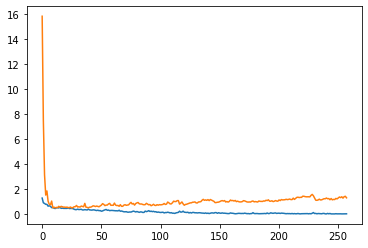

In [51]:
# plot losses
plt.plot(clf.history['train']['loss'])
plt.plot(clf.history['valid']['loss'])

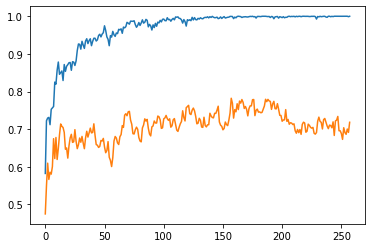

In [52]:
# plot accuracies
plt.plot([-x for x in clf.history['train']['metric']])
plt.plot([-x for x in clf.history['valid']['metric']])

In [53]:
preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"FINAL TEST SCORE FOR teste : {test_acc}")

FINAL TEST SCORE FOR teste : 0.8284671532846716


In [54]:
# or you can simply use the predict method

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR teste : {test_acc}")

FINAL TEST SCORE FOR teste : 0.8284671532846716


In [39]:
#0.7445
#0.8102
#0.8248
#0.8211
#0.8284

In [55]:
# Relatório de Classificação
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       230
           1       0.47      0.50      0.48        44

    accuracy                           0.83       274
   macro avg       0.69      0.70      0.69       274
weighted avg       0.83      0.83      0.83       274



In [56]:
clf.feature_importances_

array([5.52697597e-02, 3.20021943e-02, 4.60083639e-02, 3.21403519e-02,
       4.29147678e-02, 3.73866852e-03, 1.94627913e-02, 4.24703948e-02,
       0.00000000e+00, 4.00217920e-03, 7.38915357e-02, 3.07196302e-02,
       1.25034171e-02, 4.00568982e-02, 2.48406925e-04, 6.65161568e-02,
       9.96392951e-02, 4.03640798e-02, 7.68364498e-02, 1.13762902e-03,
       4.39135676e-02, 4.91122397e-02, 2.12022092e-02, 2.77660505e-05,
       3.22956553e-02, 7.27958735e-02, 4.04161497e-03, 6.11227696e-03,
       1.76641936e-04, 5.03991848e-02])

In [57]:
explain_matrix, masks = clf.explain(X_test)

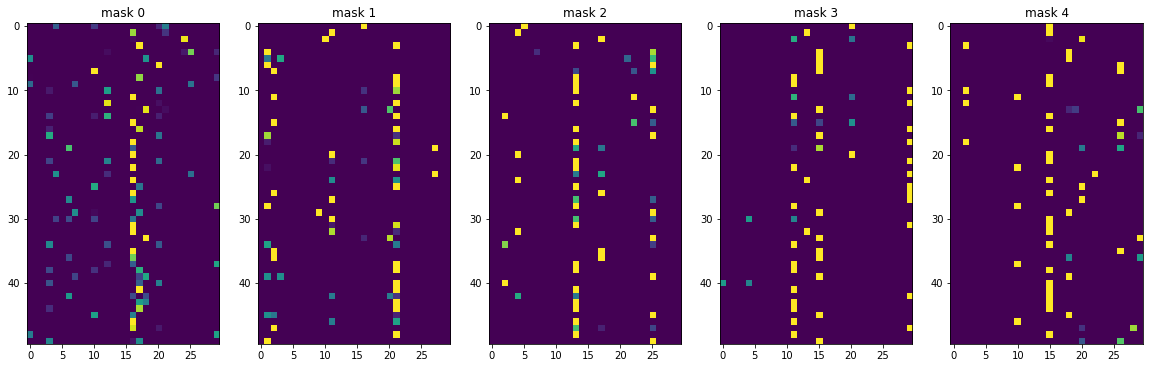

In [58]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [59]:
# save state dict
saved_filename = clf.save_model('desafio-4-model.h5')

Successfully saved model at desafio-4-model.h5.zip


In [60]:
# define new model and load save parameters
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filename)

Device used : cpu
Device used : cpu


In [61]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

loaded_test_acc = accuracy_score(y_pred=loaded_y_pred, y_true=y_test)

print(f"FINAL TEST SCORE FOR teste : {loaded_test_acc}")

FINAL TEST SCORE FOR teste : 0.8284671532846716


In [62]:
assert(test_acc == loaded_test_acc)

In [63]:
class TabNetTuner(TabNetClassifier):
    def fit(self, X, y, *args, **kwargs):
        
        self.n_d = self.n_a
        
        X_train, X_valid, y_train, y_valid = train_test_split(
            X, y, test_size=0.2, 
            random_state=42, 
            shuffle=True, 
            stratify=y
        )
        
        return super().fit(
            X_train,y_train,
            patience=100,
            X_valid=X_valid,y_valid=y_valid,
            num_workers=os.cpu_count(),max_epochs=100, 
            batch_size=1024, virtual_batch_size=256
        )

In [64]:
# define tuner
tb = TabNetTuner()

grid = {
    "n_d": [8, 16, 32, 64],
    "n_a": [8, 16, 32, 64],
    "n_independent": [1, 2, 3, 4, 5],
    "n_shared": [1, 2, 3, 4, 5], 
    "n_steps": [3, 5, 8],
    "clip_value": [1.],
    "gamma": [0.5, 1.3, 1.8, 2.],
    "momentum": [0.1, 0.05, 0.02, 0.005],
    "lambda_sparse": [0.1, 0.01, 0.001],
    #"lr": [0.1, 0.02, 0.001, 0.005],
    "verbose": [1]
}

# define searching object
rand_search = RandomizedSearchCV(
    tb, grid, n_iter=20,
    scoring="roc_auc",n_jobs=1,
    iid=False,refit=False,
    cv=[(train_indices, valid_indices)],
    verbose=1,pre_dispatch=0,
    random_state=42,
    return_train_score=False,
)

Device used : cpu


In [65]:
if "Set" not in treino.columns:
    treino["Set"] = np.random.choice(
        ["train", "valid"], p=[0.8, 0.2], size=(treino.shape[0],)
    )
    
train_indices = treino[treino.Set == "train"].index
valid_indices = treino[treino.Set == "valid"].index

# get relevant features
features = list(set(treino.columns.tolist()) - set(['Contratar']) -
                set(["Set"]) - set(['fold']) - set(['stratify_group']))

X = treino[features].values
y = treino[target].values

print(features, X.shape)
print(target, y.shape)

['Departmento', 'Satisfação com o ambiente no emprego atual', 'Estado civil', 'Genero', 'Beneficios', 'Distancia casa-trabalho', 'Pontuação teste', 'Necessita de hora extra', 'Performance na entrevista', 'Envolvimento com trabalho', 'Satisfação com emprego', 'Area', 'Anos na posição atual', 'Anos com a mesma gerência', 'Posicao', 'Local de trabalho', 'Bonus de performance', 'Anos desde última promoção', 'Quantidade de empresas que trabalho', 'Aumento de salario%', 'Horas de treinamento ultimo ano', 'Educacao', 'Renda', 'Anos de experiencia', 'Anos na última empresa', 'Cargo', 'Satisfação com a relação', 'Horas voluntariado', 'Idade', 'Estilo de vida'] (1370, 30)
Contratar (1370,)


In [66]:
rand_search.fit(X, y)
rand_search.best_params_

Device used : cpu
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


{'verbose': 1,
 'n_steps': 5,
 'n_shared': 3,
 'n_independent': 2,
 'n_d': 8,
 'n_a': 8,
 'momentum': 0.005,
 'lambda_sparse': 0.001,
 'gamma': 2.0,
 'clip_value': 1.0}

In [67]:
tab_net = TabNetClassifier(**rand_search.best_params_)

def fold_generator(fold):
    print('Fold Number: ', fold)
    
    train_labels = treino[treino.fold != fold].reset_index(drop=True)
    val_labels   = treino[treino.fold == fold].reset_index(drop=True)
    
    X_train = train_labels[features].values
    y_train = train_labels[label].values.squeeze(1)
    
    X_val   = val_labels[features].values
    y_val   = val_labels[label].values.squeeze(1)
    
    print(X_train.shape)
    print(y_train.shape)

    tab_net.fit(X_train,y_train,
              X_val,y_val,weights=1,
              max_epochs=10,patience=7, 
              batch_size=2048, virtual_batch_size=512,
              num_workers=0,drop_last=False)
    
    print("Validation score: {:<8.5f}".format(roc_auc_score(y_val,
                                                            tab_net.predict_proba(X_val)[:,1])))
    
    test[fold] = tab_net.predict_proba(test[features].values)[:,1]

Device used : cpu


In [68]:
[fold_generator(i) for i in range(3)] 

Fold Number:  0


AttributeError: 'DataFrame' object has no attribute 'fold'